# Analiza Skupień Klientów Sklepu Online

W tym notebooku przeprowadzimy analizę skupień klientów na podstawie danych transakcyjnych ze sklepu internetowego. Celem jest zidentyfikowanie różnych segmentów klientów na podstawie ich zachowań zakupowych.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer

## 1. Wczytanie i Wstępne Oczyszczanie Danych

In [3]:
# Wczytanie danych
try:
    df = pd.read_excel('./Online Retail.xlsx')
    print("Dane wczytane pomyślnie.")
except FileNotFoundError:
    print("Błąd: Plik 'Online Retail.xlsx' nie został znaleziony. Upewnij się, że znajduje się w tym samym katalogu co notebook.")
    exit()

# Podstawowe informacje o danych
print("\nKształt zbioru danych:", df.shape)
print("\nPierwsze 5 wierszy:")
print(df.head())
print("\nInformacje o typach danych i brakujących wartościach:")
print(df.info())

Dane wczytane pomyślnie.

Kształt zbioru danych: (541909, 8)

Pierwsze 5 wierszy:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  

Informacje o typach danych i brakujących wartościach:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54

### Czyszczenie Danych
- Usunięcie brakujących wartości, zwłaszcza w `CustomerID`.
- Usunięcie wierszy z `Quantity` <= 0 lub `UnitPrice` <= 0 (zwroty, błędy).
- Konwersja `InvoiceDate` na typ datetime.

In [4]:
# Usunięcie wierszy z brakującymi CustomerID, ponieważ są kluczowe dla analizy klientów
df.dropna(subset=['CustomerID'], inplace=True)
print(f"Kształt po usunięciu brakujących CustomerID: {df.shape}")

# Usunięcie wierszy z Quantity <= 0 (zwroty lub błędne wpisy)
df = df[df['Quantity'] > 0]
print(f"Kształt po usunięciu Quantity <= 0: {df.shape}")

# Usunięcie wierszy z UnitPrice <= 0 (błędne wpisy)
df = df[df['UnitPrice'] > 0]
print(f"Kształt po usunięciu UnitPrice <= 0: {df.shape}")

# Konwersja InvoiceDate na datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Sprawdzenie brakujących wartości po czyszczeniu
print("\nBrakujące wartości po czyszczeniu:")
print(df.isnull().sum())

Kształt po usunięciu brakujących CustomerID: (406829, 8)
Kształt po usunięciu Quantity <= 0: (397924, 8)
Kształt po usunięciu UnitPrice <= 0: (397884, 8)

Brakujące wartości po czyszczeniu:
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


## 2. Inżynieria Cech Klienta (RFM - Recency, Frequency, Monetary)

Zbudujemy następujące cechy dla każdego klienta:
- **Recency**: Liczba dni od ostatniego zakupu.
- **Frequency**: Całkowita liczba unikalnych transakcji (faktur).
- **Monetary**: Całkowita wartość wydanych pieniędzy.
- **AverageOrderValue**: Średnia wartość zamówienia.
- **UniqueProducts**: Liczba unikalnych produktów kupionych przez klienta.

In [5]:
# Obliczenie wartości totalnej dla każdej pozycji transakcji
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Określenie daty referencyjnej (dzień po ostatniej dacie w zbiorze danych)
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Agregacja danych na poziomie klienta
customer_features = df.groupby('CustomerID').agg(
    Recency=('InvoiceDate', lambda date: (snapshot_date - date.max()).days),
    Frequency=('InvoiceNo', 'nunique'),
    Monetary=('TotalPrice', 'sum'),
    UniqueProducts=('StockCode', 'nunique')
).reset_index()

# Obliczenie AverageOrderValue
average_order_value = df.groupby(['CustomerID', 'InvoiceNo'])['TotalPrice'].sum().reset_index()
avg_order_value_per_customer = average_order_value.groupby('CustomerID')['TotalPrice'].mean().reset_index()
avg_order_value_per_customer.rename(columns={'TotalPrice': 'AverageOrderValue'}, inplace=True)

# Dołączenie AverageOrderValue do customer_features
customer_features = pd.merge(customer_features, avg_order_value_per_customer, on='CustomerID', how='left')

print("\nWygenerowane cechy klienta:")
print(customer_features.head())
print("\nStatystyki opisowe cech klienta:")
print(customer_features.describe())


Wygenerowane cechy klienta:
   CustomerID  Recency  Frequency  Monetary  UniqueProducts  AverageOrderValue
0     12346.0      326          1  77183.60               1       77183.600000
1     12347.0        2          7   4310.00             103         615.714286
2     12348.0       75          4   1797.24              22         449.310000
3     12349.0       19          1   1757.55              73        1757.550000
4     12350.0      310          1    334.40              17         334.400000

Statystyki opisowe cech klienta:
         CustomerID      Recency    Frequency       Monetary  UniqueProducts  \
count   4338.000000  4338.000000  4338.000000    4338.000000     4338.000000   
mean   15300.408022    92.536422     4.272015    2054.266460       61.501153   
std     1721.808492   100.014169     7.697998    8989.230441       85.366768   
min    12346.000000     1.000000     1.000000       3.750000        1.000000   
25%    13813.250000    18.000000     1.000000     307.415000   

## 3. Przekształcenie i Skalowanie Danych

Cechy RFM często mają rozkłady skośne, dlatego zastosujemy transformację logarytmiczną, aby zmniejszyć wpływ wartości odstających. Następnie przeskalujemy dane za pomocą `StandardScaler`.

In [6]:
# Wybór cech do klasteryzacji
X = customer_features[['Recency', 'Frequency', 'Monetary', 'AverageOrderValue', 'UniqueProducts']]

# Zastosowanie transformacji logarytmicznej (dodanie małej stałej, aby uniknąć log(0))
X_log = np.log1p(X)

# Skalowanie danych
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_log)

print("\nPierwsze 5 wierszy przeskalowanych danych (po transformacji logarytmicznej):")
print(pd.DataFrame(X_scaled, columns=X.columns).head())


Pierwsze 5 wierszy przeskalowanych danych (po transformacji logarytmicznej):
    Recency  Frequency  Monetary  AverageOrderValue  UniqueProducts
0  1.461993  -0.955214  3.706225           7.523483       -2.526376
1 -2.038734   1.074425  1.411843           1.038408        0.965881
2  0.373104   0.386304  0.716489           0.616141       -0.367738
3 -0.623086  -0.955214  0.698739           2.445437        0.665088
4  1.424558  -0.955214 -0.618962           0.220538       -0.584387


## 4. Zastosowanie Algorytmów Klasteryzacji

Wypróbujemy dwa popularne algorytmy klasteryzacji: K-Means oraz Klasteryzację Hierarchiczną (Agglomerative Clustering). Wybierzemy optymalną liczbę klastrów dla K-Means za pomocą metody łokcia (Elbow Method) i współczynnika Silhouette.

### 4.1. K-Means - Wybór Optymalnej Liczby Klastrów (K)


Metoda łokcia (Elbow Method) dla K-Means:


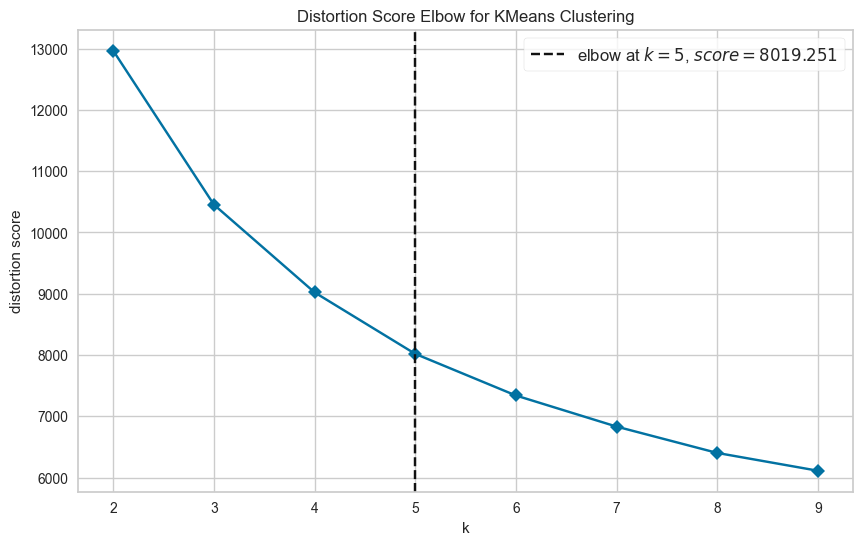

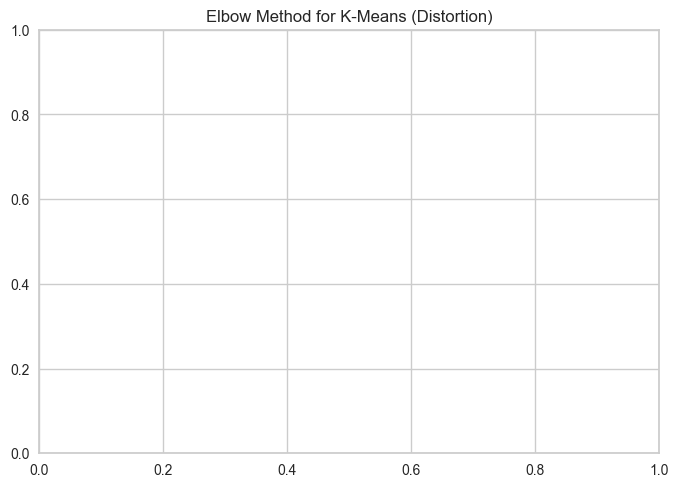


Współczynnik Silhouette dla K-Means:
K = 2, Silhouette Score: 0.3471
K = 3, Silhouette Score: 0.2536
K = 4, Silhouette Score: 0.2371
K = 5, Silhouette Score: 0.2327
K = 6, Silhouette Score: 0.2171
K = 7, Silhouette Score: 0.2151
K = 8, Silhouette Score: 0.2119
K = 9, Silhouette Score: 0.2069


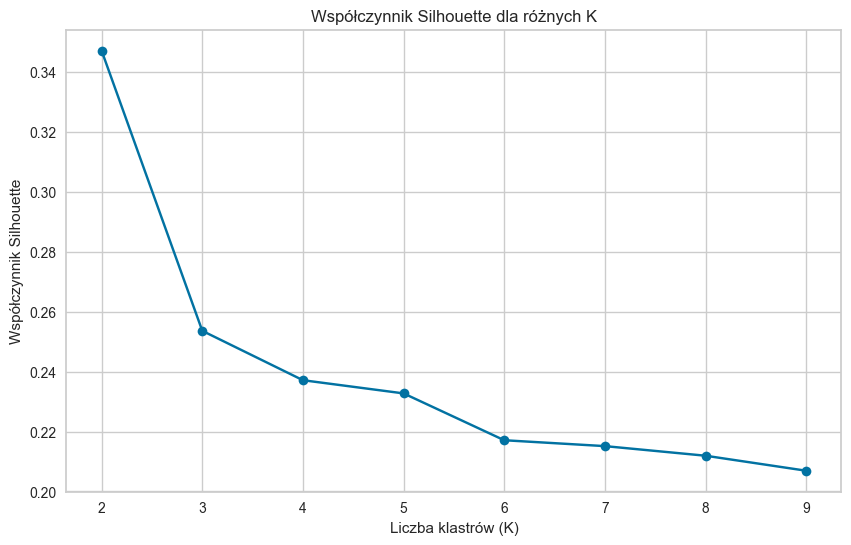


Wybrana liczba klastrów dla K-Means: 4


In [7]:
# Metoda łokcia (Elbow Method)
print("\nMetoda łokcia (Elbow Method) dla K-Means:")
model = KMeans(random_state=42, n_init='auto')
visualizer = KElbowVisualizer(model, k=(2,10), metric='distortion', timings=False)

plt.figure(figsize=(10, 6))
visualizer.fit(X_scaled)
visualizer.show()
plt.title('Elbow Method for K-Means (Distortion)')
plt.show()

# Współczynnik Silhouette (Silhouette Score)
print("\nWspółczynnik Silhouette dla K-Means:")
silhouette_scores = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)
    print(f"K = {k}, Silhouette Score: {score:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores, marker='o')
plt.xlabel('Liczba klastrów (K)')
plt.ylabel('Współczynnik Silhouette')
plt.title('Współczynnik Silhouette dla różnych K')
plt.grid(True)
plt.show()

# Na podstawie powyższych wykresów i wartości, wybierz K. 
# Często 3-5 klastrów jest dobrym punktem wyjścia dla danych RFM.
# Ustawienie K na podstawie subiektywnej oceny (np. k=4 dla tego przykładu).
n_clusters = 4 # Przykładowa wybrana liczba klastrów
print(f"\nWybrana liczba klastrów dla K-Means: {n_clusters}")

### 4.2. Klasteryzacja K-Means

In [8]:
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
customer_features['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)
print("\nRozkład klastrów K-Means:")
print(customer_features['KMeans_Cluster'].value_counts().sort_index())


Rozkład klastrów K-Means:
KMeans_Cluster
0    1072
1    1257
2     837
3    1172
Name: count, dtype: int64


### 4.3. Klasteryzacja Hierarchiczna (Agglomerative Clustering)

In [9]:
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
customer_features['Agglomerative_Cluster'] = agg_clustering.fit_predict(X_scaled)
print("\nRozkład klastrów Agglomerative Clustering:")
print(customer_features['Agglomerative_Cluster'].value_counts().sort_index())


Rozkład klastrów Agglomerative Clustering:
Agglomerative_Cluster
0    1615
1    1085
2     966
3     672
Name: count, dtype: int64


## 5. Porównanie Wyników Klasteryzacji (Metryki Wewnętrzne)

In [10]:
print("\nPorównanie metryk wewnętrznych dla algorytmów klasteryzacji:")

# K-Means
kmeans_silhouette = silhouette_score(X_scaled, customer_features['KMeans_Cluster'])
kmeans_calinski = calinski_harabasz_score(X_scaled, customer_features['KMeans_Cluster'])
kmeans_davies = davies_bouldin_score(X_scaled, customer_features['KMeans_Cluster'])

print(f"K-Means: ")
print(f"  - Współczynnik Silhouette: {kmeans_silhouette:.4f}")
print(f"  - Indeks Calinskiego-Harabasza: {kmeans_calinski:.4f}")
print(f"  - Indeks Daviesa-Bouldina: {kmeans_davies:.4f}")

# Agglomerative Clustering
agg_silhouette = silhouette_score(X_scaled, customer_features['Agglomerative_Cluster'])
agg_calinski = calinski_harabasz_score(X_scaled, customer_features['Agglomerative_Cluster'])
agg_davies = davies_bouldin_score(X_scaled, customer_features['Agglomerative_Cluster'])

print(f"\nAgglomerative Clustering: ")
print(f"  - Współczynnik Silhouette: {agg_silhouette:.4f}")
print(f"  - Indeks Calinskiego-Harabasza: {agg_calinski:.4f}")
print(f"  - Indeks Daviesa-Bouldina: {agg_davies:.4f}")


Porównanie metryk wewnętrznych dla algorytmów klasteryzacji:
K-Means: 
  - Współczynnik Silhouette: 0.2371
  - Indeks Calinskiego-Harabasza: 2028.4931
  - Indeks Daviesa-Bouldina: 1.2978

Agglomerative Clustering: 
  - Współczynnik Silhouette: 0.1607
  - Indeks Calinskiego-Harabasza: 1609.0951
  - Indeks Daviesa-Bouldina: 1.4146


## 6. Redukcja Wymiarowości i Wizualizacja

Zastosujemy Principal Component Analysis (PCA) do redukcji wymiarowości danych do dwóch komponentów, aby móc zwizualizować klastry.


Wyjaśniona wariancja przez pierwsze dwa komponenty PCA:
PC1: 0.6178
PC2: 0.2046
Suma wyjaśnionej wariancji: 0.8224


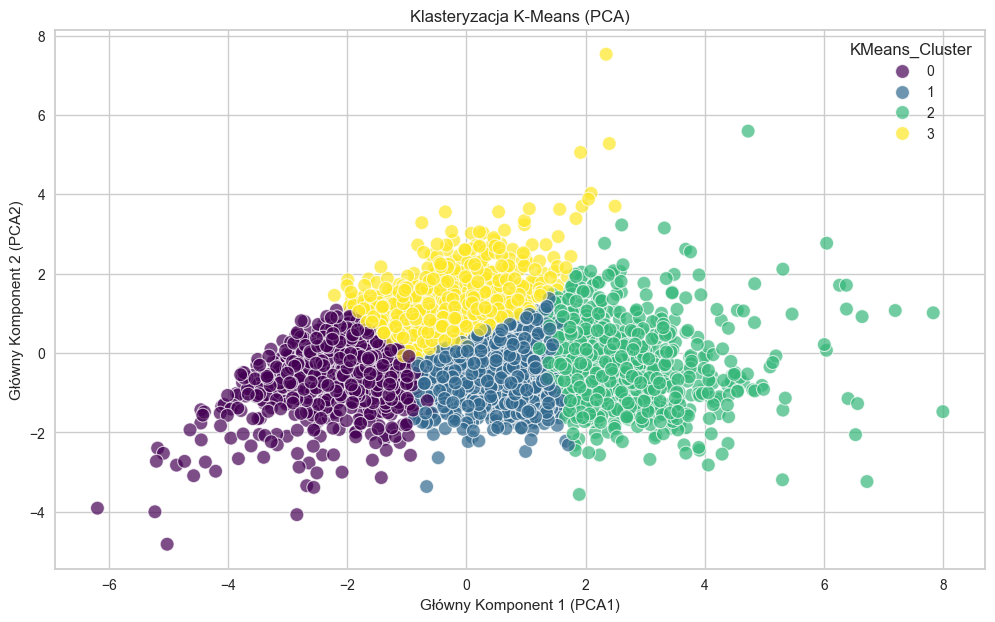

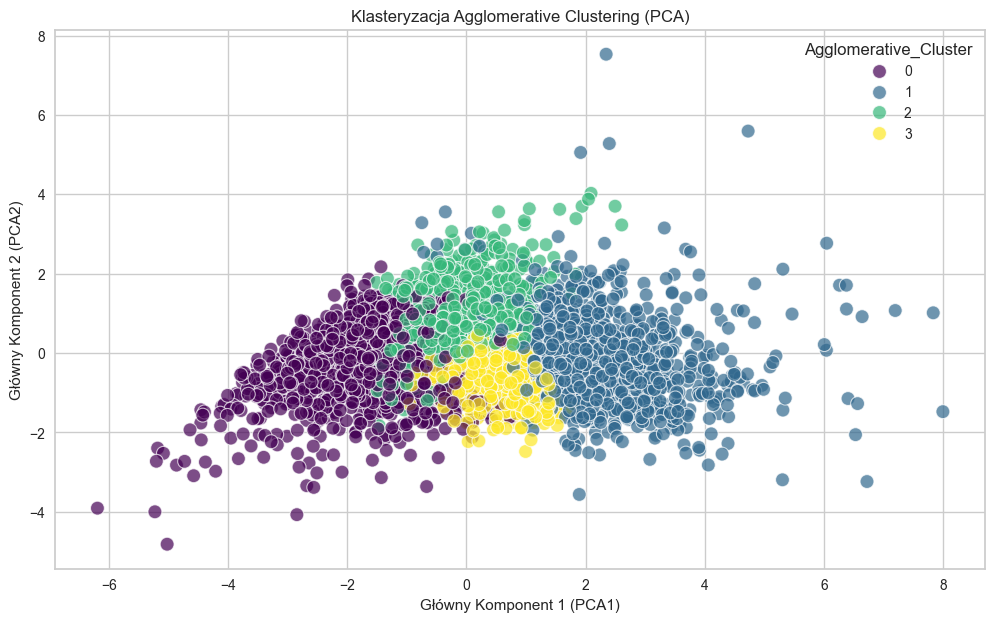

In [11]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

customer_features['PCA1'] = X_pca[:, 0]
customer_features['PCA2'] = X_pca[:, 1]

print("\nWyjaśniona wariancja przez pierwsze dwa komponenty PCA:")
print(f"PC1: {pca.explained_variance_ratio_[0]:.4f}")
print(f"PC2: {pca.explained_variance_ratio_[1]:.4f}")
print(f"Suma wyjaśnionej wariancji: {pca.explained_variance_ratio_.sum():.4f}")

# Wizualizacja K-Means
plt.figure(figsize=(12, 7))
sns.scatterplot(
    x='PCA1', y='PCA2', 
    hue='KMeans_Cluster', 
    data=customer_features, 
    palette='viridis', 
    s=100, 
    alpha=0.7, 
    legend='full'
)
plt.title('Klasteryzacja K-Means (PCA)')
plt.xlabel('Główny Komponent 1 (PCA1)')
plt.ylabel('Główny Komponent 2 (PCA2)')
plt.grid(True)
plt.show()

# Wizualizacja Agglomerative Clustering
plt.figure(figsize=(12, 7))
sns.scatterplot(
    x='PCA1', y='PCA2', 
    hue='Agglomerative_Cluster', 
    data=customer_features, 
    palette='viridis', 
    s=100, 
    alpha=0.7, 
    legend='full'
)
plt.title('Klasteryzacja Agglomerative Clustering (PCA)')
plt.xlabel('Główny Komponent 1 (PCA1)')
plt.ylabel('Główny Komponent 2 (PCA2)')
plt.grid(True)
plt.show()

## 7. Interpretacja Uzyskanych Klastrów

Aby zinterpretować klastry, przeanalizujemy średnie wartości cech RFM dla każdego klastra. Wybierzemy algorytm K-Means do interpretacji, ze względu na zazwyczaj lepszą interpretowalność klastrów (posiadają centra).


Średnie wartości cech dla każdego klastra (K-Means - oryginalne wartości):
                   Recency  Frequency     Monetary  AverageOrderValue  \
KMeans_Cluster                                                          
0               154.826493   1.469216   201.162938         145.784346   
1                33.917263   3.738266   996.370208         282.428684   
2                21.774194  12.415771  7529.884217         674.719411   
3               148.967577   1.592150   973.388048         633.369916   

                UniqueProducts  
KMeans_Cluster                  
0                    13.180970  
1                    62.398568  
2                   159.212664  
3                    34.953925  


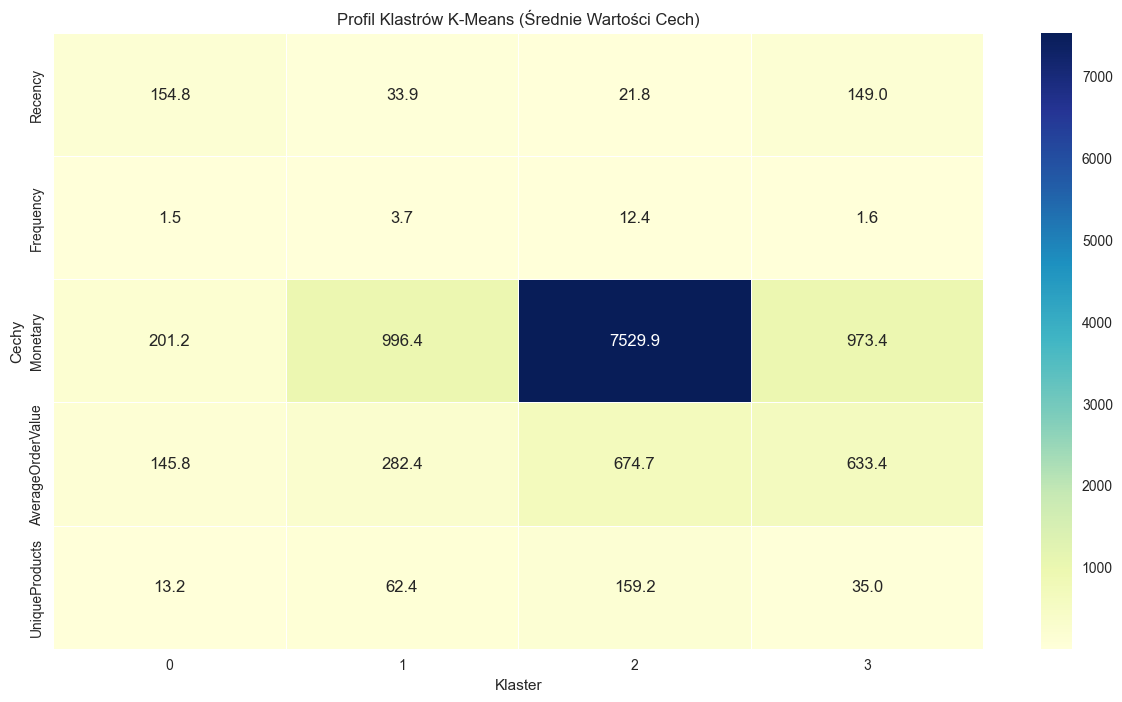

In [13]:
print("\nŚrednie wartości cech dla każdego klastra (K-Means - oryginalne wartości):")
# Używamy customer_features, aby zobaczyć średnie wartości oryginalnych (nieprzeskalowanych) cech
cluster_profiles = customer_features.groupby('KMeans_Cluster')[['Recency', 'Frequency', 'Monetary', 'AverageOrderValue', 'UniqueProducts']].mean()
print(cluster_profiles)

plt.figure(figsize=(15, 8))
sns.heatmap(cluster_profiles.T, cmap='YlGnBu', annot=True, fmt=".1f", linewidths=.5)
plt.title('Profil Klastrów K-Means (Średnie Wartości Cech)')
plt.ylabel('Cechy')
plt.xlabel('Klaster')
plt.show()

### Interpretacja Klastrów (na przykładzie K-Means z 4 klastrami):

Różnice między grupami klientów wynikają bezpośrednio ze średnich wartości cech RFM dla każdego klastra. Każdy klaster reprezentuje unikalny **segment zachowań zakupowych**:

- **Częstotliwość zakupów i świeżość:** Niektórzy klienci (np. **Lojalni**) kupują często i niedawno, podczas gdy inni (np. **Nowi/Jednorazowi**) kupują rzadko lub tylko raz.
- **Wartość wydatków:** Mamy segmenty klientów o wysokich wydatkach (np. **Lojalni**, **Klienci Wydający Dużo, Ale Rzadko**) oraz o niskich wydatkach (np. **Nowi/Jednorazowi**).
- **Charakter transakcji:** Niektórzy klienci kupują często, ale za mniejsze kwoty (np. **Lojalni** ze średnią wartością zamówienia), inni rzadko, ale z bardzo wysoką wartością pojedynczego zamówienia (np. **Klienci Wydający Dużo, Ale Rzadko**).
- **Różnorodność produktów:** Klienci Lojalni często kupują szerszy asortyment produktów w porównaniu do klientów jednorazowych.